In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import discrete_obs 

import plot

In [3]:
import intake
catalog = intake.open_esm_datastore('data/campaign-cesm2-cmip6-timeseries.json')
df = catalog.search(experiment='historical', component='ocn', stream='pop.h').df
variables = df.variable.unique()

In [4]:
[v for v in variables if 'do' in v.lower()]

['DOC',
 'DOC_RIV_FLUX',
 'DOC_prod',
 'DOC_prod_zint',
 'DOC_prod_zint_100m',
 'DOC_remin_zint',
 'DOC_remin_zint_100m',
 'DOCr',
 'DOCr_RIV_FLUX',
 'DOCr_remin_zint',
 'DOCr_remin_zint_100m',
 'DON',
 'DON_RIV_FLUX',
 'DON_prod',
 'DONr',
 'DONr_RIV_FLUX',
 'DOP',
 'DOP_RIV_FLUX',
 'DOP_diat_uptake',
 'DOP_diaz_uptake',
 'DOP_prod',
 'DOP_sp_uptake',
 'DOPr',
 'DOPr_RIV_FLUX',
 'Jint_100m_DOC',
 'Jint_100m_DOCr',
 'POC_REMIN_DOCr_zint',
 'POC_REMIN_DOCr_zint_100m',
 'diat_loss_doc_zint',
 'diat_loss_doc_zint_100m',
 'diaz_loss_doc_zint',
 'diaz_loss_doc_zint_100m',
 'graze_diat_doc_zint',
 'graze_diat_doc_zint_100m',
 'graze_diaz_doc_zint',
 'graze_diaz_doc_zint_100m',
 'graze_sp_doc_zint',
 'graze_sp_doc_zint_100m',
 'sp_loss_doc_zint',
 'sp_loss_doc_zint_100m',
 'tend_zint_100m_DOC',
 'tend_zint_100m_DOCr',
 'zoo_loss_doc_zint',
 'zoo_loss_doc_zint_100m']

In [5]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.55:40874 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
masked_area = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.).expand_dims('region')
masked_area #.plot()

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


<xarray.DataArray 'TAREA' (region: 1, nlat: 384, nlon: 320)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Dimensions without coordinates: region, nlat, nlon
Attributes:
    units:        cm^2
    long_name:    area of T cells
    coordinates:  TLONG TLAT

In [7]:
nmolcm3_to_µM = 1.

time_slice = slice("1990-01-15", "2015-01-15")
varlist = [
    'DOC',
    'DOCr',
    'DON',
    'DONr',
    'DOP',
    'DOPr',
]
ds_list = []
for variable in varlist:
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}', trust_cache=True)    
    ds_list.append(xp_func(
        time_slice, 
        variable, 
        mean_dims=['member_id', 'time'], 
    ))
    
ds = xr.merge(ds_list)
for v in ds.data_vars:
    if ds[v].attrs['units'] == 'mmol/m^3':
        ds[v].attrs['units'] = 'µM'

for v in ['DON', 'DOP', 'DOC']:
    ds[v+'_tot'] = ds[v] + ds[v+'r']
    ds[v+'_tot'].attrs['units'] = 'µM'

dsp = utils.pop_add_cyclic(ds)
dsp.info()        

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/DOC.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/DOCr.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/DON.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/DONr.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/DOP.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/DOPr.nc
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 321 ;
	z_t = 60 ;

variables:
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float32 DOC(z_t, nlat, nlon) ;
		DOC:long_name = Dissolved Organic Carbon ;
		DOC:units = µM ;
		DOC:grid_loc = 3111 ;
		DOC:cell_methods = time: mean ;
	fl

In [8]:
client.close()
cluster.close()
del client
del cluster

In [9]:
%%time
df = discrete_obs.open_datastream('DOM')
df = df.loc[df.month != 0]
for v in ['DON_tot', 'DOP_tot', 'DOC_tot']:
    df.obs_stream.add_model_field(ds[v], field_name=v)

df.obs_stream.add_model_field(ds_grid.REGION_MASK, method='nearest')
df

CPU times: user 30.9 s, sys: 122 ms, total: 31 s
Wall time: 31.6 s


,month,lon,lat,depth,DON_tot_obs,DOP_tot_obs,DOC_tot_obs,DON_tot,DOP_tot,DOC_tot,REGION_MASK
1,3.0,-49.30228,-35.08802,11.9,3.05,0.015,NaN,4.270430,0.157818,56.299896,1.0
3,3.0,-49.30228,-35.08802,28.3,5.14,0.132,NaN,4.267263,0.157763,56.265880,1.0
5,3.0,-49.30228,-35.08802,41.7,4.19,0.120,NaN,4.253699,0.157391,56.120030,1.0
7,3.0,-49.30228,-35.08802,45.1,4.79,0.118,NaN,4.248209,0.157229,56.061104,1.0
9,3.0,-49.30228,-35.08802,49.6,3.51,NaN,NaN,4.229146,0.156607,55.858052,1.0
...,...,...,...,...,...,...,...,...,...,...,...
146815,2.0,-71.70450,-32.50090,436.0,NaN,NaN,44.3825,NaN,NaN,NaN,2.0
146817,2.0,-71.70450,-32.50090,484.3,NaN,NaN,NaN,NaN,NaN,NaN,2.0
146819,2.0,-71.70450,-32.50090,565.7,NaN,NaN,54.9400,NaN,NaN,NaN,2.0
146821,2.0,-71.70450,-32.50090,663.2,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [10]:
mask3d = pop_tools.region_mask_3d('POP_gx1v7', mask_name='default')
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Black Sea', 'Baltic Sea', 'Red Sea', 'Southern Ocean', 'Pacific Ocean',
       'Indian Ocean', 'Persian Gulf', 'Atlantic Ocean', 'Mediterranean Sea',
       'Lab. Sea & Baffin Bay', 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'],
      dtype='<U21')
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'

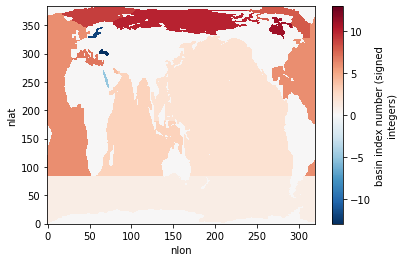

In [11]:
regions = {
    'Southern Ocean': [1],
    'Atlantic': [6], 
    'Indian': [3],
    'Pacific': [2],     
    'Arctic': [9, 10],
}
ds_grid.REGION_MASK.plot() #vmax=6)

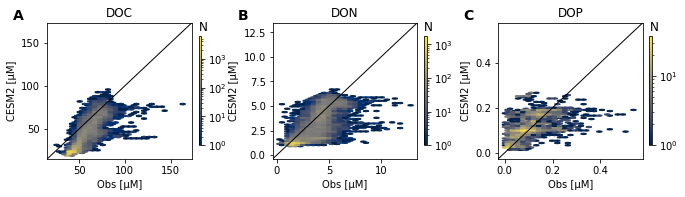

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig = plt.figure(figsize=(12, 2.5))
nrow, ncol = 1, 3 
gs = gridspec.GridSpec(
    nrows=10, ncols=ncol*3, 
    width_ratios=(1, 0.02, 0.4,)*ncol,
    wspace=0.1, 
    hspace=0.0,
)
axs = np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[:, j*3])
    

depth_range = (0., 100000.)

for n, field in enumerate(['DOC_tot', 'DON_tot', 'DOP_tot']):
    ax = axs[0, n]
    
    df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
    sc = ax.hexbin(df_sub[f'{field}_obs'], df_sub[field], 
                   mincnt=1, gridsize=(25, 25), bins='log',
                   cmap='cividis',)
    
    #if n == 0:
    ax.set_ylabel('CESM2 [µM]')
    ax.set_xlabel('Obs [µM]')
    ax.set_title(field.replace('_tot', ''))
    xlm = ax.get_xlim()
    ylm = ax.get_ylim()
    
    xylm = (np.min([xlm[0], ylm[0]]), np.max((xlm[1], ylm[1])))
    ax.plot(xylm, xylm, 'k-', lw=1)
    ax.set_xlim(xylm)
    ax.set_ylim(xylm)
    
#     cax = inset_axes(ax, width="2%", height="45%", loc='lower left',
#                  bbox_to_anchor=(0.75, 0.05, 1, 1),
#                  bbox_transform=ax.transAxes,
#                 )    
    cax = plt.subplot(gs[1:-1, n*3+1])
    cb = plt.colorbar(sc, ax=ax, cax=cax)
    #cb.set_ticks(np.arange(310,  370, 10))
    cb.ax.set_title('N', loc='left') 
    #plt.plot([0, 5], [0, 5], 'r-')
    
utils.label_plots(fig, [ax for ax in axs.ravel()],)# xoff=0.02, yoff=0)       

utils.savefig('DOM-model-obs-scatter')

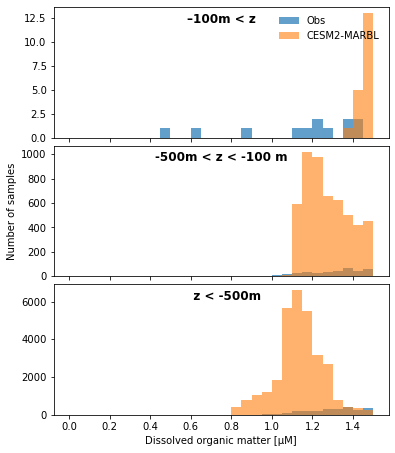

In [13]:
field = 'DON_tot'

fig, axs = plot.canvas(3, 1, figsize=(6, 2.5), use_gridspec=True, hspace=0.06)

dx = 0.05
bin_edges = np.arange(0., 1.5+dx, dx)
bins = np.vstack((bin_edges[:-1], bin_edges[1:])).mean(axis=0)

depth_ranges = {
    '–100m < z': (0., 100.),
    '-500m < z < -100 m': (100., 500.),
    '   z < -500m': (500., 1e36),
}

for n, (key, depth_range) in enumerate(depth_ranges.items()):
    ax = axs[n, 0]
    df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
    
    hist, _ = np.histogram(df_sub[f'{field}_obs'].values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.7, label='Obs')
    
    hist, _ = np.histogram(df_sub[field].values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.6, label='CESM2-MARBL')
    
    if n == 0:
        ax.legend(loc='upper right', frameon=False)
    if n < 2:
        ax.set_xticklabels([])
    ylm = ax.get_ylim()
    ax.text(0.75, ylm[1] - 0.12 * np.diff(ylm), key, 
            fontweight='bold',
            fontsize=12,
            ha='center',
           )
    if n == 1:
        ax.set_ylabel('Number of samples')
    if n == 2:
        ax.set_xlabel('Dissolved organic matter [µM]')
    

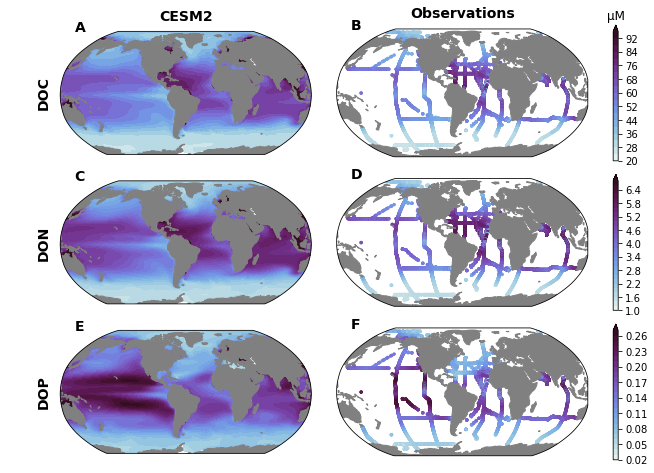

In [14]:
fields = ['DOC_tot', 'DON_tot', 'DOP_tot']

levels = {field: plot.nice_levels(df[field]) for field in fields}


fig = plt.figure(figsize=(10, 8))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = len(fields), 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol+1, 
    width_ratios=(1, 1, 0.02),
    wspace=0.15, 
    hspace=0.1,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j], projection=prj)
    caxs[i, j] = plt.subplot(gs[i, -1])

cmap_field = cmocean.cm.dense

depth_range = (0., 100.)

for i, field in enumerate(fields):    
    for j in range(2):
        ax = axs[i, j]
        
        if j == 0:
            zslice = slice(depth_range[0]*100., depth_range[1]*100.)
            cf = ax.contourf(
                dsp.TLONG,dsp.TLAT, dsp[field].sel(z_t=zslice).mean('z_t'),
                levels=levels[field],
                extend='max',
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                transform=ccrs.PlateCarree(),
            )
        else:
            df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
            sc = ax.scatter(
                df_sub.lon, df_sub.lat, c=df_sub[field].values,
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                s=6,
                transform=ccrs.PlateCarree(),)
            
        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )  

    cb = plt.colorbar(cf, cax=caxs[i, j])        
    if 'units' in dsp[field].attrs and i == 0:
        cb.ax.set_title(dsp[field].attrs['units'])
    
utils.subplot_col_labels(axs[0, :], ['CESM2', 'Observations'])    
utils.subplot_row_labels(axs[:, 0], [f.replace('_tot', '') for f in fields], xoff=60)

utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)    
         
utils.savefig('DOM-concentration-maps.pdf')

In [15]:
dsp.info()

xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 321 ;
	z_t = 60 ;

variables:
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float32 DOC(z_t, nlat, nlon) ;
		DOC:long_name = Dissolved Organic Carbon ;
		DOC:units = µM ;
		DOC:grid_loc = 3111 ;
		DOC:cell_methods = time: mean ;
	float32 DOCr(z_t, nlat, nlon) ;
		DOCr:long_name = Refractory DOC ;
		DOCr:units = µM ;
		DOCr:grid_loc = 3111 ;
		DOCr:cell_methods = time: mean ;
	float32 DON(z_t, nlat, nlon) ;
		DON:long_name = Dissolved Organic Nitrogen ;
		DON:units = µM ;
		DON:grid_loc = 3111 ;
		DON:cell_methods = time: mean ;
	float32 DONr(z_t, nlat, nlon) ;
		DONr:long_name = Refractory DON ;
		DONr:units = µM ;
		DONr:grid_loc = 3111 ;
		DONr:cell_methods = time: mean ;
	float32 DOP(z_t, nlat, nlon) ;
		DOP:long_name = Dissolved Organic Phosphorus ;
		DOP:units = µM ;
		DOP:grid_loc = 3111 ;
		DOP:cell_methods = time: mean ;
	float32 DOPr(z_t, nlat, nlon) ;
		DOPr:long_name = Refractory DOP ;
		DOPr:units = µM ;
		DOPr: